<a href="https://colab.research.google.com/github/suneetsawant/Image-Caption/blob/master/Image_Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Captioning

This notebook covers the implementation of image captioning using Deep Neural Network 

## Import all neccessary libraries 

1. Tensorflow, Keras for implementing neural network architecture 
2. Pydrive to save-restore model on google drive 
3. NLTK to calculate BLEU Scores 

In [0]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sys

import keras
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception,preprocess_input
from keras.models import Model
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import pickle
import os
from keras.preprocessing.text import Tokenizer
import shutil
from keras.utils import to_categorical
from keras.layers import Input, Dense,GRU,Embedding,GlobalMaxPooling2D,Dropout,add,CuDNNGRU,Activation

from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import *
import nltk
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Define Drive Api for download and upload model and data

In [3]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
class Drive():   
  def __init__(self) :  
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)


  def fileaction(self,files,op='up') : 
    file_list = self.drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for filename in files:
      flag = 0 

      for file1 in file_list:
        if (file1['title']) == filename :
            if (op == 'up'and flag==0) : 
                file1.Delete()
                self.upload(filename)
                flag = 1

            elif (op == 'down') : 
                self.download(filename,file1) 

      if(op=='up' and flag==0): 
            self.upload(filename)
            flag = 1

  def upload(self,filename) : 
      Uploadfile = self.drive.CreateFile({'title': filename})
      Uploadfile.SetContentFile(filename)
      Uploadfile.Upload()
      print("Saved '{}' to Drive".format(filename))

  def download(self,filename,file1): 
      downloaded = self.drive.CreateFile({'id':file1['id']})
      downloaded.GetContentFile(filename)
      print("Downloaded '{}' from Drive".format(filename))


    100% |████████████████████████████████| 993kB 19.6MB/s 


## Download Data 

We are using Flickr 30k Image Dataset which can be found [here](https://www.kaggle.com/hsankesara/flickr-image-dataset). The trick mentioned in [fast ai forums](https://forums.fast.ai/t/request-curl-from-chrome/6816/7) has been used to download the data directly to colab instance.

In [4]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/31296/39911/flickr-image-dataset.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1553448483&Signature=Q29Qbn3i3KBw5GqJUPMlGOf5mUx5HJqeFU8G%2Bc433XTiMeo33TWq9MNuts0bdLvYle8Aodjmc7BsYF0YXvfvzB4hXxYB2uV0y2e%2Fns2e385kTKauiTczErNdBqqxIMyIwu4Xxxz0%2FVxQW9J6jjg2wW3HTUZY87smdEPN%2BlFjiJwnWAsPTksxFdJT%2FP07Inxt6%2FSLlPvunZVyH0PEMhXLxhQXFhwlY8diwiB%2BCqrv1EDRGVCpLwdQY7NNK7bWR2PHRn4nqeK51fDbVtgO%2F%2BZncDPx6snJ0Ti34KpPrKKrXZQjE%2BqCsDfaK2xB%2FfoSyiNbLtW7DrfO0sczx2ltpCESqA%3D%3D" -O "flickr-image-dataset.zip" -c 
!unzip -o -qq flickr-image-dataset.zip
!ls flickr30k_images/



--2019-03-21 17:38:56--  https://storage.googleapis.com/kaggle-datasets/31296/39911/flickr-image-dataset.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1553448483&Signature=Q29Qbn3i3KBw5GqJUPMlGOf5mUx5HJqeFU8G%2Bc433XTiMeo33TWq9MNuts0bdLvYle8Aodjmc7BsYF0YXvfvzB4hXxYB2uV0y2e%2Fns2e385kTKauiTczErNdBqqxIMyIwu4Xxxz0%2FVxQW9J6jjg2wW3HTUZY87smdEPN%2BlFjiJwnWAsPTksxFdJT%2FP07Inxt6%2FSLlPvunZVyH0PEMhXLxhQXFhwlY8diwiB%2BCqrv1EDRGVCpLwdQY7NNK7bWR2PHRn4nqeK51fDbVtgO%2F%2BZncDPx6snJ0Ti34KpPrKKrXZQjE%2BqCsDfaK2xB%2FfoSyiNbLtW7DrfO0sczx2ltpCESqA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4383083308 (4.1G) [application/zip]
Saving to: ‘flickr-image-dataset.zip’

flickr-image-datase 100%[===================>]   4.08G   124MB/s    in 39s     

2019-03-21 17:39:36 (1

## PreProcess Downloaded Data
1.  Generate features for all images in dataset using Xception Net architecture. The idea is to compute and save features at start, so that we can directly download and use features, saving us some critical feature computations essentially we are in a way caching features.  
2. Divide the features into training, test, validation sets using results.csv file 
4. Saving all the features(with divisions) as different folders for future use.  

Note: This is all one time process. The data will be downloaded for training whenever required. This helps us in maintaining the same training and validation data for training as the dataset divisions are randomized.

In [0]:

def process_input(data_path,model): 
  count =0 
  total_images = len(os.listdir(data_path))
  for file in os.listdir(data_path): 
      path = data_path+file 
      img = image.load_img(path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      features = model.predict(x)

      filename = os.path.splitext(file)[0]
      count+=1
      sys.stdout.write("\r" + "Image Processed :"+str(count)+"/"+str(total_images))
      sys.stdout.flush()
      with open("features/"+filename+".feat", 'wb') as f:  
        pickle.dump(features, f)  
        
#        
xception = Xception(weights='imagenet',include_top=False)
data_directory = "./flickr30k_images/flickr30k_images/" 
os.makedirs("./features", exist_ok=True)
process_input(data_directory,xception)
#xception.summary()


!zip -r -qq features.zip ./features
#!ls -lh features
Drive().fileaction(["features.zip","results.csv"],'up')

Drive().fileaction(["features.zip","results.csv"],'down')
!unzip -o -qq features.zip

os.makedirs('data/train/features/',exist_ok=True)
os.makedirs('data/test/features/',exist_ok=True)
os.makedirs('data/validation/features/',exist_ok=True)
df = pd.read_csv('results.csv',delimiter='|')

test_feat = np.random.choice(os.listdir('features'),1000,replace=False)
for filename in test_feat:
  shutil.copy(os.path.join('./features/', filename), os.path.join('data/test/features/', filename))

train_val = set(os.listdir('features'))-set(test_feat)
val_feat = np.random.choice(list(train_val),1000,replace=False)
len(val_feat)
for filename in val_feat:
  shutil.copy(os.path.join('./features/', filename), os.path.join('data/validation/features/', filename))

train_feat = set(os.listdir('features'))-set(val_feat)-set(test_feat)
for filename in train_feat:
  shutil.copy(os.path.join('./features/', filename), os.path.join('data/train/features/', filename))
  
  
df_train = df[df['image_name'].apply(lambda x: os.path.splitext(x)[0]+".feat").isin(train_feat)]
df_train.to_csv('data/train/train.csv')

df_train = df[df['image_name'].apply(lambda x: os.path.splitext(x)[0]+".feat").isin(test_feat)]
df_train.to_csv('data/test/test.csv')

df_train = df[df['image_name'].apply(lambda x: os.path.splitext(x)[0]+".feat").isin(val_feat)]
df_train.to_csv('data/validation/validation.csv')

!zip -r -q  data.zip data/
Drive().fileaction(['data.zip'],'up')



## Download Saved Features from Drive

In [5]:


Drive().fileaction(['data.zip'],'down')
!unzip -q data.zip 
!ls 


Downloaded 'data.zip' from Drive
adc.json  data.zip	    flickr-image-dataset.zip
data	  flickr30k_images  sample_data


In [0]:
!ls 


flickr30k_images  flickr-image-dataset.zip  sample_data


In [0]:

def create_feature_column(df):
    df['train_feat'] = df['image_name'].apply(lambda x: os.path.splitext(x)[0]+".feat")
    return df
  
def create_tokenizer(df):
    
    tokenizer = Tokenizer(oov_token='UNK',num_words=10000)
    tokenizer.fit_on_texts(df[' comment'].tolist()) 
    
    vocab_size = tokenizer.num_words + 3 ## extra 3 for UNK,start_seq,end_seq 
    
    return tokenizer, vocab_size
  
def create_subsequences(df,X,Y,tokenizer,vocab_size):
  
    seq = df[' comment']
    seq = tokenizer.texts_to_sequences([seq])[0]

    
    start_seq_token = vocab_size - 1
    end_seq_token   = vocab_size - 2

    seq.insert(0,start_seq_token)
    seq.append(end_seq_token)

    for i in range(1,len(seq)):
        inp,out = seq[:i],seq[i]  
        X.append((inp,df['train_feat']))
        Y.append(out)  

def load_data(df_train,df_val,vocab_size): 
    X_train,X_val,Y_train,Y_val = [],[],[],[]
    
    df_train.apply(lambda x:create_subsequences(x,X_train,Y_train,tokenizer,vocab_size),axis=1)
    df_val.apply(lambda x:create_subsequences(x,X_val,Y_val,tokenizer,vocab_size),axis=1)
    
    return X_train,X_val,Y_train,Y_val


### Read Train/Val Data and Create **tokenizer**

In [7]:


# Read Training data 
df_train = pd.read_csv('data/train/train.csv')
df_train = create_feature_column(df_train) 
df_train[' comment'] = df_train[' comment'].astype(str)
# Create tokenizer from training data
tokenizer,vocab_size = create_tokenizer(df_train) 

# Read validation data 
df_val = pd.read_csv('data/validation/validation.csv')
df_val = create_feature_column(df_val) 

X_train,X_val,Y_train,Y_val = load_data(df_train,df_val,vocab_size)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
fun = lambda x : 1e-6+0.4*(np.exp(x/0.3e4)/1e7)
x = np.arange(26835*2)
val = list(fun(x))
plt.plot(x,val)

In [0]:
class DataGenerator():
    def __init__(self,batchsize,feature_path,sequence_length,vocab_size):
        self.batchsize = batchsize
        self.feature_path = feature_path
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        
    def generate(self,X,Y):
        while 1 : 
            index = np.arange(len(X))
            np.random.shuffle(index)
            
            size = int(len(X)/self.batchsize)

            for i in range(size):
                Id = [(X[x],Y[x]) for x in index[i*self.batchsize:(i+1)*self.batchsize] ]
                
                x1,x2,y = self.data_gen(Id)
                
                yield [[x1,x2],y] 

    def data_gen(self,Id):
        X1 =[]
        X2= []
        y = []

        for element in Id : 
          
          #print(element)
          train_feat = element[0][1]
          
          with open(self.feature_path+train_feat, 'rb') as fp:
              x = pickle.load(fp)
              
   
          inp = pad_sequences([element[0][0]], maxlen=self.sequence_length,padding='post')[0]
          out = np.expand_dims(element[1], -1)
         
          X1.append(x[0])
          X2.append(inp)
          y.append(out)
          
        return np.array(X1),np.array(X2),np.array(y)

## Define the Model

In [0]:
def compute_loss(mask_value):
    #mask_value = K.variable(mask_value)
    def masked_categorical_crossentropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character '#'
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        # multiply categorical_crossentropy with the mask
        loss = K.sparse_categorical_crossentropy(y_true, y_pred) * mask

        # take average w.r.t. the number of unmasked entries
        return K.sum(loss) / K.sum(mask)
    return masked_categorical_crossentropy

masked_categorical_crossentropy = compute_loss(0)


def compute_accuracy(mask_value):
    #mask_value = K.variable(mask_value)
    def masked_categorical_accuracy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character '#'
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        # multiply categorical_crossentropy with the mask
        acc = keras.metrics.sparse_categorical_accuracy(y_true, y_pred) * mask

        # take average w.r.t. the number of unmasked entries
        return K.sum(acc) / K.sum(mask)
    return masked_categorical_accuracy

masked_categorical_accuracy = compute_accuracy(0)

def compute_perplexity(mask_value):
  def perplexity(y_true, y_pred):
      mask = K.all(K.equal(y_true, mask_value), axis=-1)
      mask = 1 - K.cast(mask, K.floatx())
      cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)* mask
      cross_entropy = K.sum(cross_entropy) / K.sum(mask)
      pp = K.exp(cross_entropy)
      #pp = K.sum(pp) / K.sum(mask)
      return pp
  return perplexity

perplexity = compute_perplexity(0) 

def log2(x):
  oneoverlog2 = 1.442695
  return K.log(x)*oneoverlog2


def create_model (image_input_shape,batch_size,sequence_length,vocab_size,embedding_dim,drop_prob) : 
  
    input1 = Input( batch_shape = image_input_shape, name = "Image_Input")
    image_input = GlobalMaxPooling2D(data_format='channels_last')(input1)  # output shape = (_,2048)
    image_out = Dropout(drop_prob)(image_input)
    image_out = Dense(1024)(image_out)
    image_out = BatchNormalization()(image_out)
    image_out = Activation('tanh')(image_out)



    input2 = Input( batch_shape = (batch_size,sequence_length), name = "description_input")
    desc_input = Embedding(vocab_size,embedding_dim,input_length = sequence_length) (input2) #output shape = (_,max_length,512) 
    desc_input = Dropout(drop_prob)(desc_input)
    GRU1 = CuDNNGRU(1024,return_sequences=True)(desc_input,initial_state=image_out)
    GRU2 = CuDNNGRU(1024,return_sequences=True)(GRU1,initial_state=image_out)
    GRU3 = CuDNNGRU(1024)(GRU2,initial_state=image_out)


    #decoder1 = add([image_out, GRU_out])
    #decoder2 = Dense(256, activation='relu')()
    outputs = Dense(vocab_size)(GRU3)
    outputs = BatchNormalization()(outputs)
    outputs = Activation('softmax')(outputs)



    model = Model(inputs=[input1,input2], outputs=outputs)
    #TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']


    #tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,
    #strategy=tf.contrib.tpu.TPUDistributionStrategy(
     #   tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    
    
    #tpu_model.compile(
    #    optimizer=tf.train.AdamOptimizer(),
     #   loss=tf.keras.losses.categorical_crossentropy,
    #    metrics=['accuracy'])
    adam = optimizers.adam()

    model.compile(loss=masked_categorical_crossentropy, optimizer=adam ,metrics=[masked_categorical_accuracy,perplexity])


    return model








###For efficient tuning of learning rate,  we are using  [Cyclical Learning Rate Policy](https://arxiv.org/abs/1506.01186)

In [0]:
class CyclicLR(Callback):
    def __init__(self, base_lr=1e-6, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def fun(self): 
        return  self.base_lr + 0.4*(np.exp(self.clr_iterations/0.3e4)/1e7)

        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())  
            #K.set_value(self.model.optimizer.lr, self.fun())  
            
    def on_batch_end(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        #self.history.setdefault('loss',[]).append(logs.get('loss'))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        #K.set_value(self.model.optimizer.lr, self.fun())

### Define Parameters


In [0]:
sequence_length    = 40
embedding_dim      = 256 
batch_size         = 64
image_input_shape  = (batch_size,7,7,2048)
drop_prob = 0.1
epochs = 4

train_feature_path = "data/train/features/"
val_feature_path   = "data/validation/features/"

train_steps = len(X_train)/batch_size
validation_steps = len(X_val)/batch_size
tf.keras.backend.clear_session()

In [0]:
!rm -r ./log

In [0]:
class TB(TensorBoard):
    def __init__(self, log_every=1, **kwargs):
        super().__init__(**kwargs)
        self.log_every = log_every
        self.counter = 0
    
    def on_batch_end(self, batch, logs=None):
        self.counter+=1
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        if self.counter%self.log_every==0:
            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, self.counter)
           
            summary = tf.Summary(value=[tf.Summary.Value(tag='lr',
                                                     simple_value=K.get_value(self.model.optimizer.lr))])
            self.writer.add_summary(summary, batch)     
            self.writer.flush()
        
        super().on_batch_end(batch, logs)
        
    def on_epoch_end(self, epoch, logs=None):
        for name, value in logs.items():
            if (name in ['batch', 'size']) or ('val' not in name):
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()   
        
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
tbCallBack = TB(log_dir='./log',log_every=1, histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)         

--2019-01-20 15:33:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.9.96, 34.206.36.121, 34.204.22.7, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.9.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.70MB/s    in 0.7s    

2019-01-20 15:33:31 (7.70 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://2005412e.ngrok.io


### Training loop for the model 

In [0]:
train_generator = DataGenerator(batch_size,train_feature_path,sequence_length,vocab_size).generate(X_train,Y_train)
val_generator   = DataGenerator(batch_size,val_feature_path,sequence_length,vocab_size).generate(X_val,Y_val) 
filepath = "weights2.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=1, 
                                   save_best_only=True, mode='auto')


cycliclr = CyclicLR(base_lr=1e-5, max_lr=4e-5,mode='triangular2',step_size = train_steps*2 )
callbacks_list = [checkpoint,cycliclr,tbCallBack]

Drive().fileaction(['weights2.hdf5'],'down') 

keras.backend.clear_session()
#del model
model = create_model(image_input_shape,batch_size,sequence_length,vocab_size,embedding_dim,drop_prob)
#model.summary()
model.load_weights('weights2.hdf5')
for it in range(epochs) :
    train_history = model.fit_generator(generator = train_generator,steps_per_epoch=train_steps, epochs=1,validation_data=val_generator
                    ,validation_steps=validation_steps,verbose=1,callbacks=callbacks_list)
   
    Drive().fileaction(['weights2.hdf5'],'up') 
    !nvidia-smi


In [0]:
!ls 

adc.json  data	data.zip  sample_data  weights2.hdf5


## Evaluate 

We will be using beam search decoder as well as greedy decoder. As beam decoder uses lots of computation time,  we are evaluating all results using greedy decoder.

In [12]:
Drive().fileaction(['weights2.hdf5'],'down') 
image_dir = os.listdir('flickr30k_images/flickr30k_images/')
xception = Xception(weights='imagenet',include_top=False)


output_word = ""
count = 0 
token = vocab_size - 1
output_tokens = [token]
seq_model = create_model(image_input_shape,batch_size,sequence_length,vocab_size,embedding_dim,drop_prob=0)
#model.summary()
seq_model.load_weights('weights2.hdf5')




Downloaded 'weights2.hdf5' from Drive
Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step


In [0]:

def generate_caption(path,img_model,seq_model,tokenizer):
  seq = ""
  #imag=mpimg.imread(path)
  #plt.imshow(imag)

  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  image_features = img_model.predict(x) 
    
  token = [vocab_size - 1]
  for i in range(sequence_length):  
    if i!=0 : 
      token = tokenizer.texts_to_sequences([seq])[0]
      token.insert(0,vocab_size-1)
    pad_seq = pad_sequences([token],maxlen=sequence_length,padding='post')
    out = seq_model.predict([image_features,pad_seq])
    yhat = np.argmax(out)
    if yhat==vocab_size-2 : break
    seq += " "+tokenizer.index_word[yhat]
  return seq

def compute_BLEU(seq,image_name,df):
    references = df[df['image_name']==image_name][' comment'].apply(lambda x:x.lower().strip().split()[:-1])
    #print(list(references))
    hypothesis = seq
    hypothesis = hypothesis.strip().split() 
    BLEUscore = nltk.translate.bleu_score.sentence_bleu(references, hypothesis,smoothing_function= nltk.translate.bleu_score.SmoothingFunction().method1) 
    return BLEUscore
def evaluate(path,df,beam_width,length,beam_decoder):
  files = os.listdir(path) 
  blue = []
  
  count = 1
  #for file in np.random.choice(files,1) :
      
  for file in files:  
      image_name = os.path.splitext(file)[0]+'.jpg'
      #image_name = "3656010396.jpg"
      #print(image_name)
      
      #print("Without BeamSearch =", seq)
      #print(bleu)
      image_path = 'flickr30k_images/flickr30k_images/'+image_name

      if beam_decoder: 
        seq,_ = generate_caption_beam_search(image_path,xception,seq_model,tokenizer,beam_width,length)
        bleu = compute_BLEU(seq,image_name,df)
      else : 
        seq = generate_caption(image_path,xception,seq_model,tokenizer)
        bleu = compute_BLEU(seq,image_name,df)
      blue.append(bleu)
      sys.stdout.write("\rEvaluation Progress: {}/{} -- BLEU SCORE: {:.4f} ".format(count,len(files),bleu))
      sys.stdout.flush()
      #print(bleu)
      #print(seq)
      imag=mpimg.imread(image_path)
      #plt.imshow(imag)
      count = count + 1
  print("Avg_Bleu Score = ",np.array(blue).mean())    
def beam_search(sequence,probablity,length,image_features,beam_width):
  if(length==20) : return sequence,probablity,length
  
  length = length + 1 
  
  if(sequence==""): 
    token = [vocab_size-1]
  else :  
    token = tokenizer.texts_to_sequences([sequence])[0]
    token.insert(0,vocab_size-1)
  pad_seq = pad_sequences([token],maxlen=sequence_length,padding='post')
  probs = np.squeeze(seq_model.predict([image_features,pad_seq]))
  
  top_indices = np.argsort(-probs,axis=-1)[:beam_width]
  #print("top_index= ",top_indices)
  seq_ = []
  prob_ = [] 
  
  for idx in top_indices: 
      if(idx==vocab_size-2) : 
          #print("--------------------------------------  here ----------------------------------------------------------")
          seq_.append(sequence)
          prob_.append(probablity)
      else :     
          seq = sequence + " " + tokenizer.index_word[idx] 
          prob = probs[idx] * probablity

          seq,prob,leng = beam_search(seq,prob,length,image_features,beam_width)
          seq_.append(seq)
          prob_.append(prob) 
  idx  = np.argmax(prob_)
  
  if (length%20==0) : 
    y=1
    #print("seq= ",seq_[idx]," CumulativeProbability = ",prob_[idx])
  return seq_[idx],prob_[idx],length
  
  
def generate_caption_beam_search(path,img_model,seq_model,tokenizer,beam_width,length):
  seq = ""
  #imag=mpimg.imread(path)
  #plt.imshow(imag)

  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  image_features = img_model.predict(x)
  token = [vocab_size-1]
  pad_seq = pad_sequences([token],maxlen=sequence_length,padding='post')
  #print(pad_seq)
  probs = np.squeeze(seq_model.predict([image_features,pad_seq]))
  
  top_indices = np.argsort(-probs,axis=-1)[:beam_width]
  
  token = [[vocab_size-1,x] for x in top_indices]
  
  prob = np.ones((beam_width,1))
  #print("TOken =", token)
  #print(image_features.shape)
  image_features = np.repeat(image_features,beam_width,axis=0)
  #print(image_features.shape)
  #seq,prob,_ =  beam_search(seq,probablity=1,length=0,image_features=image_features,beam_width=beam_width)
  
  
  seq,prob,_ = modified_beam_search(token,prob,length=0,image_features=image_features,beam_width=beam_width,output_length=length)

  args = np.argmax(np.array(prob))
  
  #print(seq)
  #print(seq[args])
  #print(prob)
  
  seq = index_to_word(seq[args])
  return seq,prob


In [0]:
def remove(lst,element): 
  m = lst[:]
  m.remove(element)
  return m
def append(lst,element): 
  m =lst[:]
  m.append(element)
  return m
def index_to_word(token): 
  seq = ""
  for ind in token: 
    if(ind!=vocab_size-1 | ind!=vocab_size-2): 
      seq += " "+ tokenizer.index_word[ind]
      #print(seq)
  return seq
def modified_beam_search(token,probabilities,length,image_features,beam_width,output_length): 
    
    if(length==output_length) : return token,probabilities,length
    length = length + 1 
        
    pad_seq = pad_sequences(token,maxlen=sequence_length,padding='post')
    #print(pad_seq)
    probs = np.squeeze(seq_model.predict([image_features,pad_seq]))
    
    #print(probs.shape)

    top_indices = np.argsort(-probs,axis=-1)[:,:beam_width]
    #print("top_index= ",top_indices)
    top_probs = np.sort(-probs,axis=-1)[:,:beam_width]
    #print("prob=",top_probs)
    seq_ = []
    prob_ = [] 
    
    for i in range(beam_width):
        
        top_idx = top_indices[:,i] 
        prob_top  = -top_probs[:,i]
        #print(top_idx)
        #[token[j].append(top_idx[j]) if top_idx[j]!=vocab_size-2 else token[j] for j in range(len(token))]
        token = [append(token[j],top_idx[j]) if top_idx[j]!=vocab_size-2 else token[j] for j in range(len(token))]
        probab = [prob_top[j]*probabilities[j] if top_idx[j]!=vocab_size-2 else probabilities[j] for j in range(len(token))]
        
        #print("Tokens =   ", token)
        #print("Probabs=" , probab)

        tok,prob,leng = modified_beam_search(token,probab,length,image_features,beam_width,output_length)
        seq_.append(tok)
        prob_.append(prob)
        
        #print("seq=",  seq_)
        #print("prob=", prob_)
        
        token = [remove(token[j],top_idx[j]) if (top_idx[j]!=vocab_size-2) & (top_idx[j] in token[j]) else token[j] for j in range(len(token))]
        
    
    x = np.zeros((beam_width,1))
    for i in range(len(prob_)): 
        x = np.concatenate((x,prob_[i]),axis=-1)
    args =  np.argmax(x,axis=1)   
    token = []
    prob = []
    for i in range(beam_width): 
        token.append(seq_[args[i]-1][i])
        prob.append(prob_[args[i]-1][i]) 
    
    #print("token=",token) 
    #print("x=",x)
    #print("final Seq  =", seq_)
    #print("prob =", prob_)
    
    #print("final_prob=",prob)
      
    return token,prob,length  


In [15]:
test_path = 'data/test/features/'
df_test = pd.read_csv('data/test/test.csv')

train_path = 'data/train/features/'
df_train = pd.read_csv('data/train/train.csv')

beam_width = 1
evaluate(test_path,df_test,beam_width,8,False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Evaluation Progress: 1000/1000 -- BLEU SCORE: 0.1153 Avg_Bleu Score =  0.10209094011646835


In [0]:
def plot_images(path,df,beam_width,length,beam_decoder):
  files = os.listdir(path) 
  blue = []
  
  count = 1
  for file in np.random.choice(files,1) :
      
  #for file in files:  
      image_name = os.path.splitext(file)[0]+'.jpg'
      #image_name = "3656010396.jpg"
      print(image_name)
      
      #print("Without BeamSearch =", seq)
      #print(bleu)
      image_path = 'flickr30k_images/flickr30k_images/'+image_name

      if beam_decoder: 
        seq,_ = generate_caption_beam_search(image_path,xception,seq_model,tokenizer,beam_width,length)
        bleu = compute_BLEU(seq,image_name,df)
      else : 
        seq = generate_caption(image_path,xception,seq_model,tokenizer)
        bleu = compute_BLEU(seq,image_name,df)
      blue.append(bleu)
      #sys.stdout.write("\rEvaluation Progress: {}/{} -- BLEU SCORE: {:.4f} ".format(count,len(files),bleu))
      #sys.stdout.flush()
      print(bleu)
      print(seq)
      imag=mpimg.imread(image_path)
      plt.figure()
      plt.imshow(imag)
      count = count + 1
  #print("Avg_Bleu Score = ",np.array(blue).mean())

## Results 

The following are some of the best results we could find on test dataset. We could see that even though image description make sense but bleu score is not good.

In [0]:
lst = ['5668948557.jpg','3457315666.jpg','7036326155.jpg','4091988557.jpg','4781814479.jpg',
      '3286045254.jpg','77587237.jpg','217838128.jpg','173170364.jpg','2635908229.jpg','2566140647.jpg','5280521648.jpg',
       '2971431335.jpg','1419394636.jpg','7721977472.jpg','1409731198.jpg','2095478050.jpg','2228156682.jpg','712563326.jpg']

In [0]:
from IPython.core.display import Image, display

def plot_image(path,df,beam_width,length,beam_decoder,image_name):
      files = os.listdir(path) 
      blue = []

      count = 1
      
      #image_name = "3656010396.jpg"
      print(image_name)
      
      #print("Without BeamSearch =", seq)
      #print(bleu)
      image_path = 'flickr30k_images/flickr30k_images/'+image_name
      if beam_decoder: 
        seq,_ = generate_caption_beam_search(image_path,xception,seq_model,tokenizer,beam_width,length)
        bleu = compute_BLEU(seq,image_name,df)
      else : 
        seq = generate_caption(image_path,xception,seq_model,tokenizer)
        bleu = compute_BLEU(seq,image_name,df)
      blue.append(bleu)
      #sys.stdout.write("\rEvaluation Progress: {}/{} -- BLEU SCORE: {:.4f} ".format(count,len(files),bleu))
      #sys.stdout.flush()
      print("BLEU SCORE : ", bleu)
      print(seq)
      imag= mpimg.imread(image_path)
      #plt.figure()
      #plt.imshow(imag)
      display(Image(filename = image_path))
      count = count + 1
  #print("Avg_Bleu Score = ",np.array(blue).mean())

3457315666.jpg
BLEU SCORE :  0.1457378792180198
 a dog jumping over a hurdle


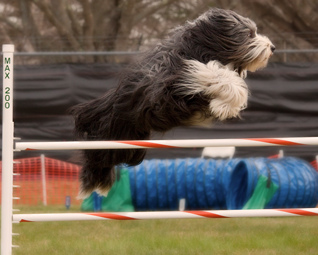

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])


173170364.jpg
BLEU SCORE :  0.21204736304688324
 a man and woman eating at a restaurant


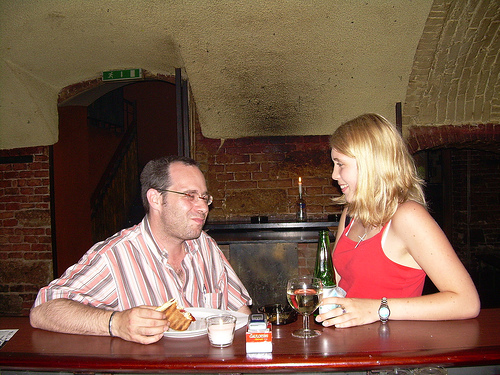

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

217838128.jpg
BLEU SCORE :  0.5193071778680676
 a man and a boy rowing a canoe on a lake


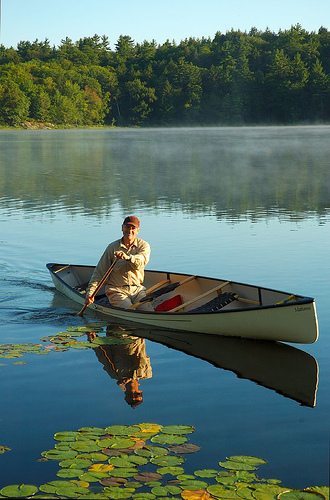

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

5280521648.jpg
BLEU SCORE :  0.1634812655665549
 a scientist in a lab coat is reading a book


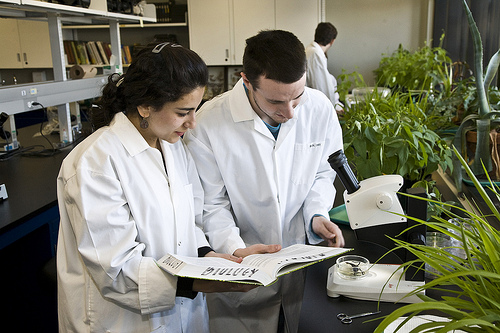

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

2228156682.jpg
BLEU SCORE :  0.4916776273205992
 a female tennis player wearing a blue outfit is about to hit the ball


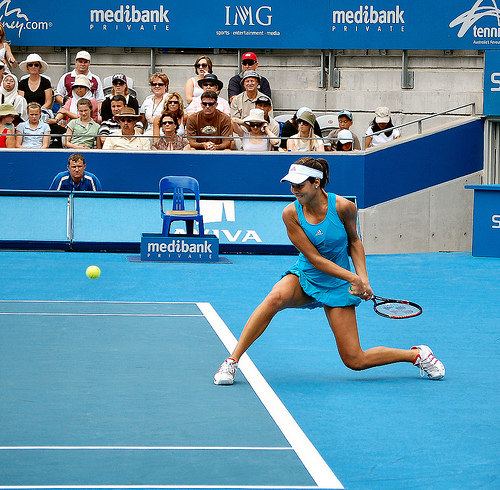

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

1409731198.jpg
BLEU SCORE :  0.488923022434901
 many people are gathered at a carnival


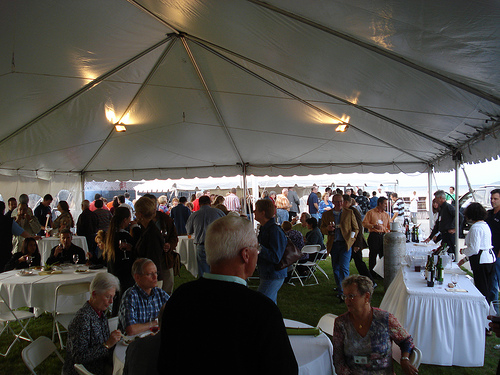

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

4091988557.jpg
BLEU SCORE :  0.37342112655242105
 a man on a bmx bike performing a trick in midair


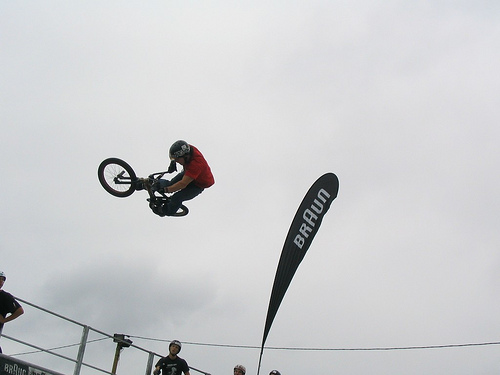

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])

2095478050.jpg
BLEU SCORE :  0.02777619034011792
 a group of musicians perform on the street for money


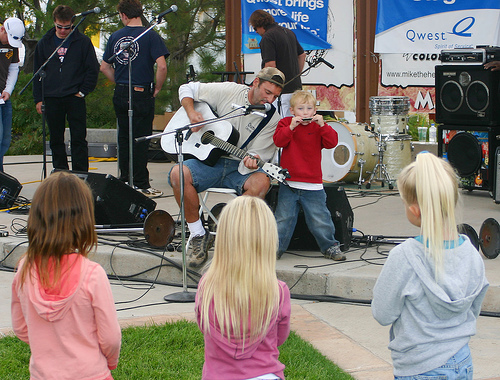

In [0]:
image_name = np.random.choice(lst,1)
plot_image(test_path,df_test,beam_width,40,False,image_name[0])